In [1]:
from global_vars import *
from func import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os

In [2]:
# ",".join(os.listdir('/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/lablmaps/NAKO'))
data_dir

'/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI'

In [3]:
def load_nako_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data166_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        
        opp_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_opp/**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_in/**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_F/**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_W/**.nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths
        

In [4]:
file_paths = load_nako_file_paths()

In [5]:
 print(json.dumps(file_paths,sort_keys=True, indent=4))

{
    "100006": {
        "LABEL_PATHS": [
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd",
            "datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd",
            "datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd",
            "datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd"
        ],
        "VOLUME_PATHS": {
            "F": [
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100006/100006

In [6]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [7]:
# TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on opp scans of {vol}...')
    vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
    idx = 0
    file_paths[vol]['N4_1'] = []
    for opp_img, bias_field_img, opp_file in vol_parts:
        file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
        idx+=1
#         n4_dict[vol].append(rescale(opp_image, vol, n4_dict[vol]))



In [8]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
#     file_paths[vol]['ONE_ORIG'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
#         save_volume(ras_stitched_orig, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'
#         file_paths[vol]['ONE_ORIG'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig.nii.gz'

started with 100094...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -395.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -587.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -815.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.406

0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100025
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -211.99302673]
 [   0.            1.40625       0.         -178.90625   ]
 [   0.            0.            3.         -418.03955078]
 [   0.            0.            0.            1.        ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -211.99302673]
 [   0.            1.40625       0.         -178.90625   ]
 [   0.            0.            3.         -610.03955078]
 [   0.            0.            0.            1.        ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -211.99302673]
 [   0.            1.40625       0.         -178.906

0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100129
started with 100013...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -425.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -617.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -845.     ]
 [   0.         0.         0.         1. 

0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100161
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -226.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -405.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -226.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -597.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -226.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -825.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320

0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100183
started with 100006...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -203.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -447.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -203.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -639.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -203.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -867.5    ]
 [   0.         0.         0.         1. 

0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100035
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -236.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -402.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -236.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -594.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -236.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -822.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320

0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100085
started with 100181...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -248.89984131]
 [   0.            1.40625       0.         -178.90625   ]
 [   0.            0.            3.         -432.23031616]
 [   0.            0.            0.            1.        ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -248.89984131]
 [   0.            1.40625       0.         -178.90625   ]
 [   0.            0.            3.         -624.23034668]
 [   0.            0.            0.            1.        ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -248.89984131]
 [   0.            1.40625 

Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -825.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.4062500e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  1.4062500e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100112
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0

0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100142
started with 100017...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -472.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -664.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -892.5    ]
 [   0.         0.         0.         1. 

0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100009
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -238.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -445.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -238.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -637.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -238.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -865.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320

0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100116
started with 100020...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -442.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -634.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -862.5    ]
 [   0.         0.         0.         1. 

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100008
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -231.09375   ]
 [   0.            1.40625       0.         -214.43591309]
 [   0.            0.            3.         -384.76696777]
 [   0.            0.            0.            1.        ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -231.09375   ]
 [   0.            1.40625       0.         -214.43591309]
 [   0.            0.            3.         -576.76696777]
 [   0.            0.            0.            1.        ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -231.09375   ]
 [   0.            1

Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -238.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -857.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.4062500e+00  0.0000000e+00  0.0000000e+00 -2.3859375e+02]
 [ 0.0000000e+00  1.4062500e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0975000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp/NAKO/n4_corrected/vol/100097
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -238.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         

In [9]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

n4 processing part-2 started with 100094...
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0550000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
-122.0
neagtive value detected
saving directory: temp/NAKO/n4_corrected/vol/100094
n4 processing part-2 started with 100025...
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.11993027e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.07803955e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
-116.0
neagtive value detected
saving directory: temp/NAKO/n4_corrected/vol/10002

saving directory: temp/NAKO/n4_corrected/vol/100008
n4 processing part-2 started with 100083...
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0600000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
-144.0
neagtive value detected
saving directory: temp/NAKO/n4_corrected/vol/100083
n4 processing part-2 started with 100097...
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3859375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0975000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
-111.0
neagtive value detected
saving directo

In [10]:
# TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on stitched opp scans of {vol}...')

    opp_file = file_paths[vol]['ONE']['OPP']
    n4_counterpart = n4_dict[vol]['N4_2']
    print(opp_file, n4_counterpart['IN_BIAS'])
    opp_img = read_ras(opp_file)
    bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

    file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

applying n4 bias field on stitched opp scans of 100094...
temp/NAKO/n4_corrected/vol/100094/OPP_ras_stitched.nii.gz temp/NAKO/n4_corrected/vol/100094/IN_ras_stitched_n4_scaled_bias_field.nii.gz
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0550000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0550000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
saving directory: temp/NAKO/n4_corrected/vol/100094
applying n4 bias field

Transforming Images to RAS.....
saving directory: temp/NAKO/n4_corrected/vol/100085
applying n4 bias field on stitched opp scans of 100181...
temp/NAKO/n4_corrected/vol/100181/OPP_ras_stitched.nii.gz temp/NAKO/n4_corrected/vol/100181/IN_ras_stitched_n4_scaled_bias_field.nii.gz
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.48899841e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.09223022e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.48899841e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.09223022e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 

Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0600000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
saving directory: temp/NAKO/n4_corrected/vol/100083
applying n4 bias field on stitched opp scans of 100097...
temp/NAKO/n4_corrected/vol/100097/OPP_ras_stitched.nii.gz temp/NAKO/n4_corrected/vol/100097/IN_ras_stitched_n4_scaled_bias_field.nii.gz
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3859375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0975000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to

In [11]:
with open('nako_file_paths.p', 'wb') as handle:
    p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [12]:
with open('nako_file_paths.p', 'rb') as handle:
    file_paths = p.load(handle)
    
print(json.dumps(file_paths, indent=4))

{
    "100094": {
        "VOLUME_PATHS": {
            "OPP": [
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_1.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_2.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_3.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_4.nii.gz"
            ],
            "IN": [
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_1_e2.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_2_e2.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/NAK

In [13]:
def nako_vol_label_fix(vol, label):
    vol_vol = np.product(vol.shape)
    label_vol = np.product(label.shape)
    
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    print(tuple(world_shape))
    final_label = np.zeros(tuple(world_shape))

    label_affine = label.affine
    vol_affine = vol.affine
    if(vol_vol>label_vol):
#         final_label = np.zeros(vol.shape)
        target_affine = vol_affine
        target_header = vol.header
        target_dim_v = vol.shape
        
#         labelmap2vol = npl.inv(target_affine).dot(label_affine)
#         start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
#         sx, sy,sz = start_inv
#         end_inv = apply_affine(labelmap2vol, target_dim_v).astype(np.int32)
#         final_label = np.zeros(end_inv)
#         ex, ey, ez = end_inv
#         print("seg start inv v: ",start_inv , "segm end inv v:",end_inv)
        sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
        print(sx,sy,sz,ex,ey,ez)
        final_label[0:ex+sx, 0:ey+sy, sz:ez] = label.get_fdata()
        final_label = np.flip(final_label, axis=0)
        final_label = np.flip(final_label, axis=1)
        final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
        volume, label = vol, final_label_img
    else:
#         final_label = np.zeros(label.shape)
        target_affine = label_affine
        target_header = label.header
        target_dim_v = label.shape
        
#         labelmap2vol = npl.inv(target_affine).dot(vol_affine)
#         start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
#         sx, sy,sz = start_inv
#         end_inv = apply_affine(labelmap2vol, target_dim_v).astype(np.int32)
#         final_label = np.zeros(end_inv)
#         ex, ey, ez = end_inv
#         print("seg start inv v: ",start_inv , "segm end inv v:",end_inv)
        sx,sy,sz,ex,ey,ez = np.abs(get_points(vol, label))
        print(sx,sy,sz,ex,ey,ez)
        final_label = np.flip(final_label, axis=0)
        final_label = np.flip(final_label, axis=1)
        final_label[0:ex+sx, 0:ey+sy, sz:ez] = vol.get_fdata()
        
        final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
        volume, label = final_label_img, label
    
    return volume, label

def get_freequent_shape(arr, axis=0):
    arr = np.array(arr)
    print(arr)
    u, indices = np.unique(arr, return_inverse=True)
    f_shape = u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),
                                    None, np.max(indices) + 1), axis=axis)]
    print(f_shape)
    return f_shape

def label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])##np.max([img.shape for img, _, _ in label_parts], axis=0)
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape
    print('final_label_stitching shape:',label_shape)
    print('reference label shape:', len(label_parts), reference_labelmap.shape)
    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print('lp:bfr:', lidx, lname, labelmap_img.shape, np.unique(labelmap_img.get_fdata()))
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        print(np.unique(labelmap_img.get_fdata()), labelmap_img.shape)
        
        sx,sy,sz,ex,ey,ez = get_points(labelmap_img, reference_labelmap)
        sx,sy,sz,ex,ey,ez = np.abs([sx,sy,sz,ex,ey,ez])
        print('label_points:', sx,sy,sz,ex,ey,ez)
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        x, y, z = labelmap.shape
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
100094
['datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Spleen.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Re

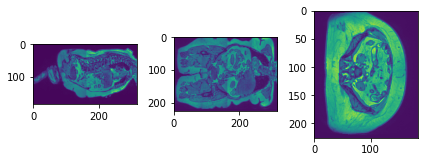

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0550000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


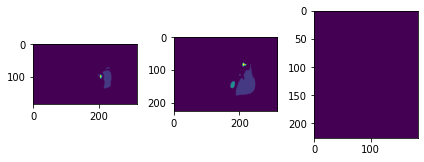

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100025
['datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver-2.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right) .nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D

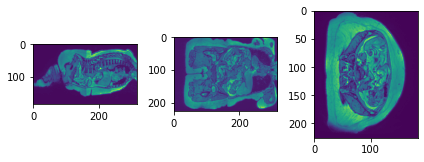

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.11993027e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.07803955e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)


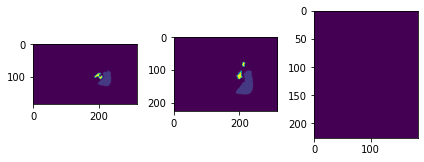

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100129
['datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Spleen.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Liver.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Kidney (right)-2.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Adrenal gland(left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files.....
Read

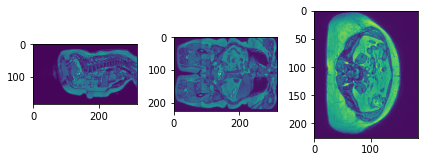

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0850000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


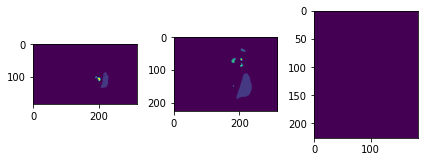

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100013
['datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2-3_subcutan_fat.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100013/100113_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_2_spleen.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GTE_TRA_opp_2_nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GR_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Panc

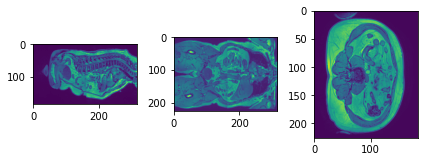

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0850000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


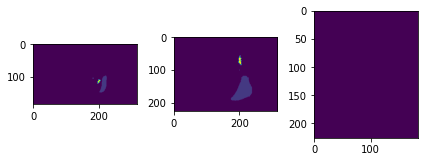

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100161
['datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Spleen.nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Pancreas.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d conf

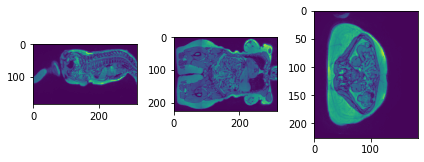

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2609375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


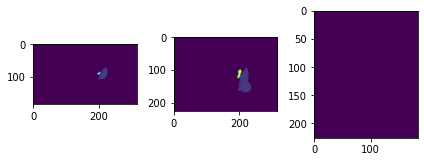

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100183
['datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Liver-2.nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Spleen.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d conf

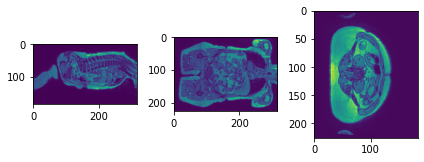

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.9140625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0300000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


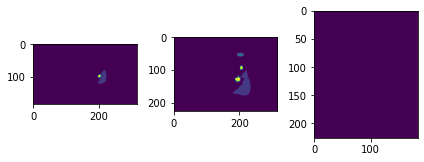

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100006
['datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Fi

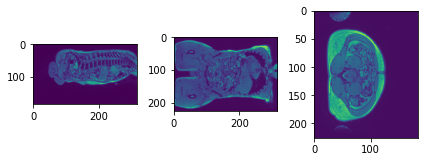

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.0359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1075000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


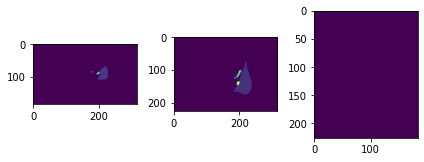

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100035
['datasets/lablmaps/NAKO/100035/35_spl.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_2_nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd']
Reading Fi

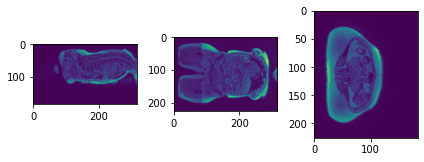

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3609375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0625000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


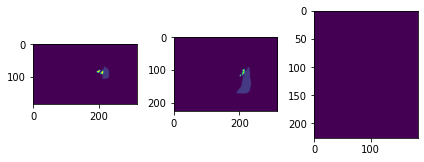

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100085
['datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(left).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver-2-2.nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files.....
Reading N

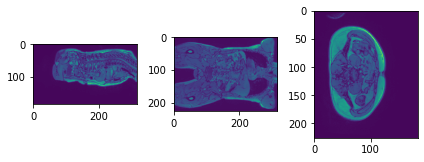

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1125000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


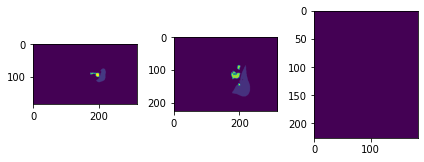

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100181
['datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Spleen-2.nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Liver-4.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files.....
Reading 

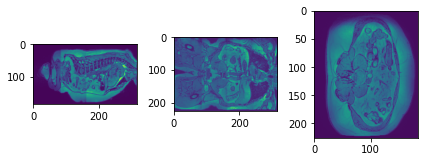

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.48899841e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.09223022e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)


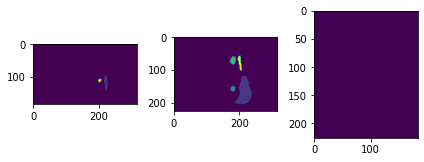

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100112
['datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Read

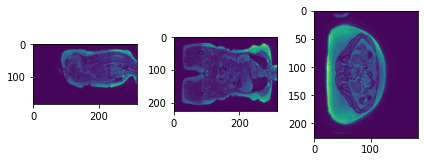

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


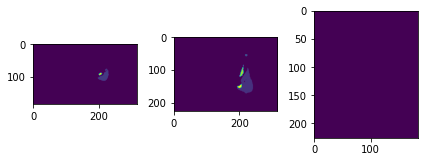

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100142
['datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files.....
Reading NRRD Files.....
Transforming I

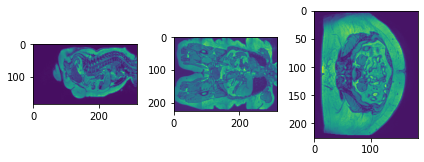

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.6640625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0825000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


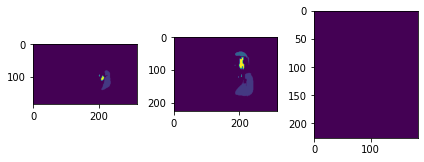

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100017
['datasets/lablmaps/NAKO/100017/100017 _3D_GRE_TRA_opp_3D_GRE_TRA_2_subcutaneous.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_2_nii_Spleen.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas-2.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GTE_TRA_opp_2_nii_Liver-2-3.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Ki

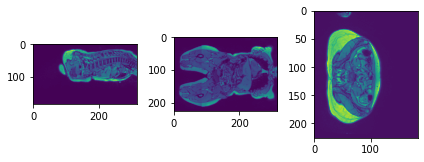

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.1609375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1325000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


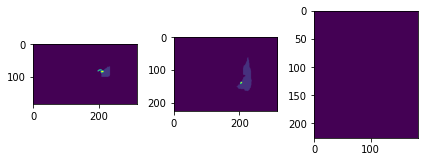

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100009
['datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files.....
Reading NRRD Files....

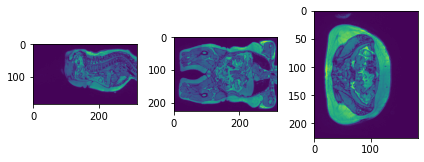

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3859375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1050000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


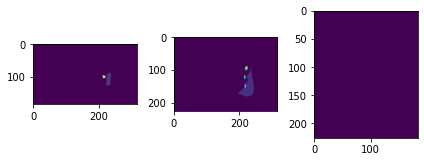

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100116
['datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Spleen.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Liver.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Adrenal gland(right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files.....
Readin

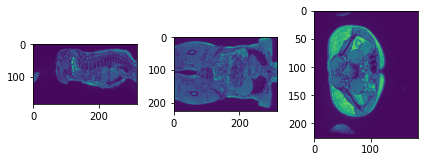

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0750000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


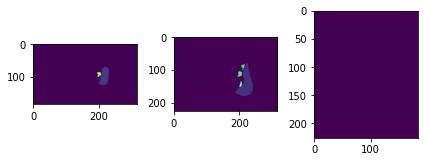

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100020
['datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder (1).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100020/10020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA

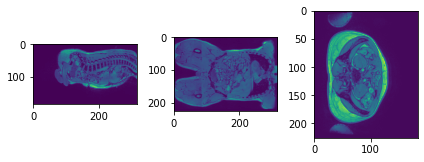

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1025000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


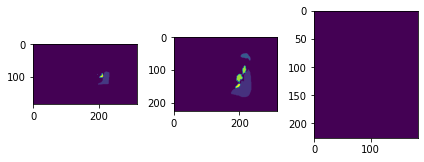

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100008
['datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Spleen-5.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder (1).nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100008/10008_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right) (1).nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_1_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(left)-4.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas-3.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_T

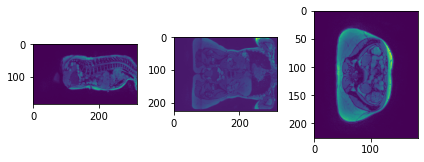

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.31093750e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -2.14435913e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04476697e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)


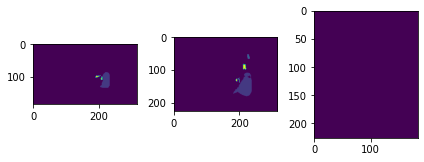

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100083
['datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(left).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(right).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files.....
Reading NRRD Files.....


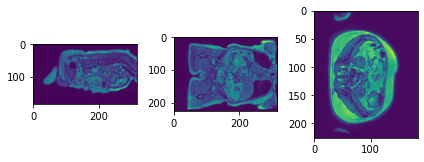

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0600000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


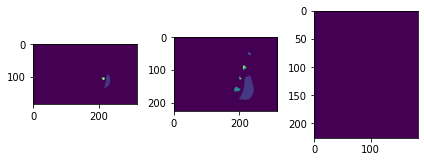

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100097
['datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Spleen.nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Liver.nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96)
After 3d confirmed: (320, 260, 96)
Reading Files....

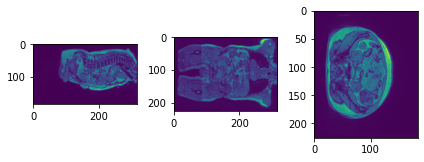

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3859375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0975000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


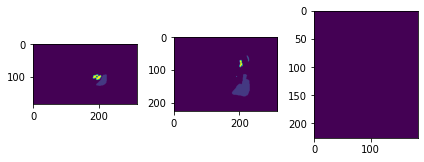

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.


In [14]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = None
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None or img_ras is None:
            continue
        print(img_ras.shape)
        img_ras = makeit_3d(img_ras)
        print('After 3d confirmed:', img_ras.shape)
        mode='constant'
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=0, mode=mode, cval=0)
        img_ras = labels_integerify(img_ras)
    #     img_ras = resample_from_to(img_ras, [volume.shape, img_ras.affine])
        if labelname == 'SPLEEN':
            later = [img_ras, lidx, labelname]
        else:
            img_ras_list.append([img_ras, lidx, labelname])
    if later is not None:
        img_ras_list.append(later)
    s_label = label_parts(img_ras_list)
    volume, s_label = nako_vol_label_fix(volume, s_label)
    #     volume, stitched_label = combine_nako_seg(file_paths[vol]['LABEL_PATHS'],'' ,file_paths[vol]['N4_2']['OPP_CORRECTED'])

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))

    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')
    
    


100094


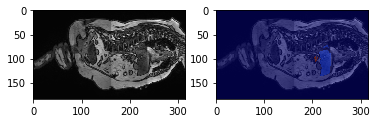

100025


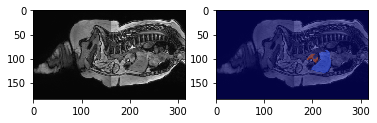

100129


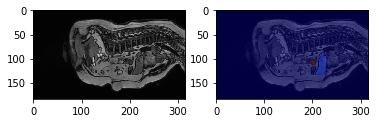

100013


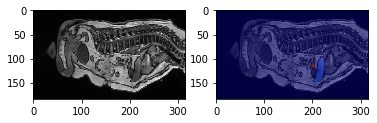

100161


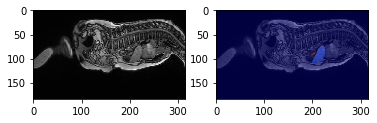

100183


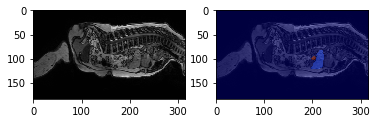

100006


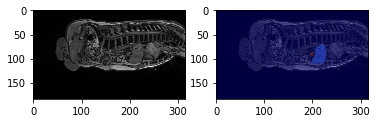

100035


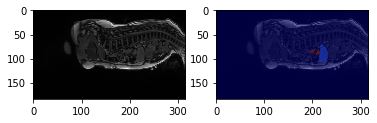

100085


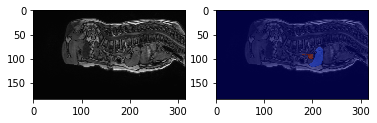

100181


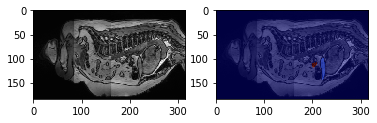

100112


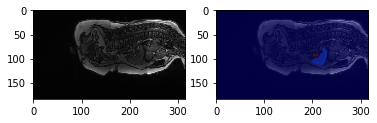

100142


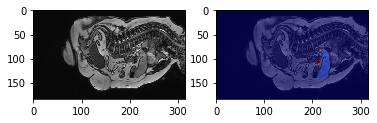

100017


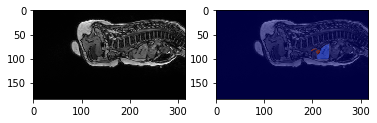

100009


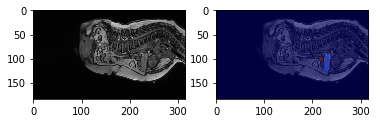

100116


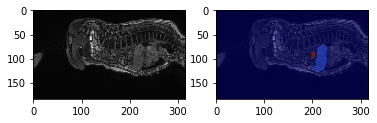

100020


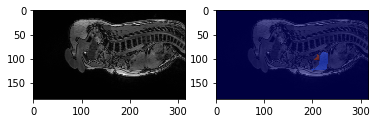

100008


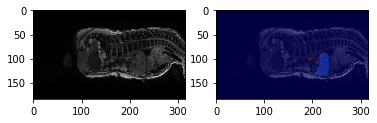

100083


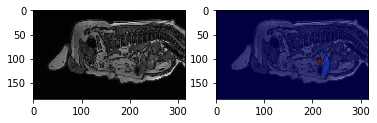

100097


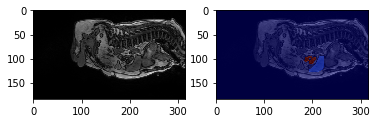

In [15]:
visualize_overlay(file_paths)


In [ ]:
# file_dict= 
# {
#     VOL_ID: {
#         VOLUME_PATHS: {
#             OPP: [],
#             IN: [],
#             F: [],
#             W: []
#         },
#         LABEL_PATHS: [],
#         N4_1: [
#             {
#                 SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#                 IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#                 IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#                 OPP_CORRECTED: '',
#                 MIN: u_min,
#                 MAX: u_max
#             },
#             {},
#             {}
#         ],
#         ONE: {
#             OPP: '',
#             IN: '',
#             F: '',
#             W: '',
#         },
#         N4_2: {
#             SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#             IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#             IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#             OPP_CORRECTED: '',
#             MIN: u_min,
#             MAX: u_max
#         },
        
#     }
# }